In [1]:
import numpy as np
import random
import copy
import math

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

num_drones = 8
drone_id = 0
population = []

In [2]:
class Drone:
    id = 0
    x = 0
    y = 0
    x_move = 0
    y_move = 0
    coverage = 3
    rely_on = None
    send_to = None
    connected_to = []
    is_dead = False
    nn = None
    
    def __init__(self):
        global drone_id
        self.id = drone_id
        drone_id += 1
        self.connected_to = []
        self.rely_on = None
        self.send_to = None
        self.nn = None
        
    def __repr__(self):
        return str(self.id)
    
    def neural_init(self):
        self.nn = NeuralNetwork(self.get_input_layer())
    
    def get_input_layer(self):
        rely_on_sig = -1
        #print(self, "relies on", self.rely_on)
        if self.rely_on != None:
            rely_on_sig = drone_sig_strength(self, self.rely_on)
        
        #print(self, "sends to", self.send_to)
        send_to_sig = -1
        if self.send_to != None:
            send_to_sig = drone_sig_strength(self, self.send_to)
        
        in_layer = [self.x*5, self.y*5, rely_on_sig, send_to_sig, self.x_move, self.y_move]
        #in_layer = [sigmoid(self.x*5), sigmoid(self.y*5), sigmoid(rely_on_sig), sigmoid(send_to_sig), self.x_move, self.y_move]
        #out_layer_form = np.array([[0],[0],[0],[0]])
        in_layer = np.array([in_layer])
        #self.nn = NeuralNetwork(in_layer, out_layer_form)
        return in_layer
        
    def neural_net_feedforward(self, input_layer):
        #print(input_layer)
        movement = self.nn.feedforward(input_layer)
        #print(self, movement)
        self.x_move = movement[0][0]
        self.y_move = movement[0][1]

In [3]:
#https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6 
def sigmoid(x):
    #print(x, '\n')
    #return 2*((1.0/(1+ np.exp(-0.5*(x-1)))-0.5))
    return (np.sin(x)+1)*.5
    #return ((np.tanh(.05*(x-50))+1)*.5)

class NeuralNetwork:
    def __init__(self, x):
        self.input      = x
        #print(self.input)
        self.weights1   = np.random.rand(self.input.shape[1], 4)
        #print(self.weights1)
        self.weights2   = np.random.rand(4, 8)  
        #print(self.weights2)
        self.weights3   = np.random.rand(8, 2)  
        #print(self.weights3)
        
        #self.output = np.zeros(y.shape)
        
    def feedforward(self, input_layer):
        #For simplicity, biases are assumed to be zero
        self.layer1 = sigmoid(np.dot(input_layer, self.weights1))
        #print(self.layer1)
        self.layer2 = sigmoid(np.dot(self.layer1, self.weights2))
        #print(self.layer2)
        self.output = sigmoid(np.dot(self.layer2, self.weights3))
        #print(self.output)
        return self.output

In [4]:
def vertices_of_regpoly(n, r, map_size):
    vertices = []
    x = []
    y = []
    for i in range(0, n):
        #x.append(math.floor(( map_size / 2) + r * math.cos(2 * math.pi * i / n)))
        #y.append(math.floor(( map_size / 2) + r * math.sin(2 * math.pi * i / n)))
        x.append(( map_size / 2) + r * math.cos(2 * math.pi * i / n))
        y.append(( map_size / 2) + r * math.sin(2 * math.pi * i / n))
    vertices.append(x)
    vertices.append(y)
    return vertices

In [5]:
def set_init_drones(swarm):
    xy = vertices_of_regpoly(num_drones, 2, swarm.the_map.size)
    for i in range(0, len(swarm.drones)):
        swarm.drones[i].x = xy[0][i]
        swarm.drones[i].y = xy[1][i]

In [6]:
class Swarm:
    drones = []
    connectedness = []
    
    def __init__(self, drones, map_size):
        self.the_map = GeoMap(map_size)
        self.drones = drones
        global drone_id
        drone_id = 0
        set_init_drones(self)
        self.assign_connectedness()
        self.assign_drone_connect()
        self.rssi_table = []
        determine_architecture(self)
        determine_neighbors(self)
        for drone in self.drones:
            drone.neural_init()
            
    
    def assign_connectedness(self):
        #Make the swarm's connectivity matrix
        #This matrix is really only used for initial configuration
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        self.connectedness = np.zeros((len(self.drones),len(self.drones)))

        #The upper traingle of a mtrix w/o diagonal is filled in with 1s
        #the diagonal would mean drones are connected to themselves
        #the lower triangle is just a reflection
        #representation of the connections between drones
        for i in range(0,len(self.drones)):
            for j in range(0, i):
                self.connectedness[j][i] = 1

        # Ensure that each drone has at least one connection
        for i in range(0,len(self.drones)):
            possible_values = np.nonzero(self.connectedness[i])[0].tolist()
            choice = random.choice(possible_values) if possible_values else -1
            if choice != -1:
                possible_values.remove(choice)
            #Remaining choices have a possibility of not being connections (probability related to the number of drones)
            for value in possible_values:
                self.connectedness[i][value] = 0 if random.random() > 1.0/float(len(self.drones)) else 1

        #reflect over diagonal axis of matrix to make symmetric matrix
        for i in range(0,len(self.drones)):
            for j in range(0, i):
                self.connectedness[i][j] = self.connectedness[j][i]
    
    def assign_drone_connect(self):
        #Assign list connectedness in drones
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        for i in range(0,len(self.connectedness)):
            for j in range(0, len(self.connectedness)):
                if self.connectedness[i][j] == 1:
                    self.drones[i].connected_to.append(self.drones[j])
    

In [7]:
def determine_fitness(swarm):
    trues = 0
    for x in range(0, len(swarm.the_map.search_points)):
        for y in range(0, len(swarm.the_map.search_points[x])):
              if swarm.the_map.search_points[x][y]:
                trues += 1
    return float(trues)/float(swarm.the_map.size)

In [8]:
def determine_architecture(swarm):
    coordinator = None
    for drone in swarm.drones:
        if coordinator == None:
            coordinator = drone
            rssi = 0
        else:
            rssi = drone_sig_strength(drone, coordinator)
        init_rssi_table(drone, rssi, swarm.rssi_table)
    sort_table_by_rssi(swarm.rssi_table)

In [9]:
def init_rssi_table(node_check, rssi, rssi_table):
    node = {}
    node["node"] = node_check
    node["rssi"] = rssi
    rssi_table.append(node)

In [10]:
def sort_table_by_rssi(rssi_table):
    rssi_table.sort(key=lambda val: val["rssi"])

In [11]:
def determine_neighbors(swarm):
    if len(swarm.rssi_table) > 1:
        for index in range(0, len(swarm.rssi_table)):
            node = swarm.rssi_table[index]['node']
            if index == 0:
                node.rely_on = None
                node.send_to = swarm.rssi_table[index + 1]['node']
            elif index == len(swarm.rssi_table) - 1:
                node.rely_on = swarm.rssi_table[index - 1]['node']
                node.send_to = None
            else:
                node.rely_on = swarm.rssi_table[index - 1]['node']
                node.send_to = swarm.rssi_table[index + 1]['node']

In [12]:
def create_starting_population(size, map_size):
    population = []
    
    global num_nodes
    for i in range(0,size):
        population.append(create_new_member(num_drones, map_size))
        
    return population

In [13]:
def create_new_member(num_drones, map_size):
    drones = []
    for i in range(0, num_drones):
        drones.append(Drone())
    member = Swarm(drones, map_size)
    return member

In [14]:
def plot_swarm(swarm):
    fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
    for drone in swarm.drones:
        plt.plot(drone.x, drone.y, 'x', color='black')
        #print(drone.x, drone.y)
        circle1 = plt.Circle((drone.x, drone.y), drone.coverage, color = 'b', fill=False)        
        ax.add_artist(circle1)

    #fig.savefig('plotcircles.png')
        
    # Draws a visualization for the network connections    
    for row in range(0, num_drones - 1):
        for col in range(row + 1, num_drones):
            if swarm.connectedness[row][col] == 1:
                plt.plot([swarm.drones[row].x, swarm.drones[col].x], 
                         [swarm.drones[row].y, swarm.drones[col].y])

In [15]:
def points_in_circle(x0, y0, radius):
    x_ = np.arange(x0 - radius - 1, x0 + radius + 1, dtype=int)
    y_ = np.arange(y0 - radius - 1, y0 + radius + 1, dtype=int)
    x, y = np.where((x_[:,np.newaxis] - x0)**2 + (y_ - y0)**2 <= radius**2)
    # x, y = np.where((np.hypot((x_-x0)[:,np.newaxis], y_-y0)<= radius)) # alternative implementation
    for x, y in zip(x_[x], y_[y]):
        yield x, y
        plt.plot(x, y, '.', color='blue')

In [16]:
class GeoMap:
    search_points = []
    searched_points = set()
    def __init__(self, size):
        self.size = size
        self.populate_search_points()
        
    def draw_map(self):
        plt.plot([0,0, self.size, self.size, 0], 
                 [0, self.size, self.size,0, 0])
        self.disp_search_points()
        #self.disp_searched_points()
        
    def disp_search_points(self):
        for x in range(0, len(self.search_points)):
            for y in range(0, len(self.search_points[x])):
                if self.search_points[x][y]:
                    plt.plot(x, y, '.', color='green')
    
    def disp_searched_points(self):
        for point in self.searched_points:
            plt.plot(point[0], point[1], '.', color='green')
        
    def populate_search_points(self):
        for i in range(0, self.size + 2):
            row = []
            for j in range(0, self.size + 2):
                row.append(False)
            self.search_points.append(row)

In [17]:
def drone_distance(drone1, drone2):
    return abs(math.hypot(drone2.x - drone1.x, drone2.y - drone1.y))

def drone_sig_strength(drone1, drone2):
    #return 20*math.log10(1/math.pow(drone_distance(drone1, drone2),2))
    #return 1/math.pow(drone_distance(drone1, drone2),2)
    dist = drone_distance(drone1, drone2)
    #print(dist)
    try:
        return  10*2*math.log10(dist) + 1
    except ValueError:
        print(dist)
        return -1

def swarm_sig_strength(swarm):
    swarm_strength = []
    
    for i in range(0, num_drones):
        for j in range(0, i):
            if swarm.connectedness[i][j] == 1:
                #print('Signal strength between drone ', i, ' and drone ', j, ': ', end='')
                #print(drone_sig_strength(swarm.drones[i], swarm.drones[j]))
                dist = drone_distance(swarm.drones[i], swarm.drones[j])
                sig_strength = drone_sig_strength(swarm.drones[i], swarm.drones[j])
                swarm_strength.append([[j, i], dist , sig_strength])
    return swarm_strength

In [18]:
def check_drone_coverage(swarm):
    #Only check the points that are within the area that drones are searching
    min_x = swarm.the_map.size + 1
    max_x = 0
    min_y = swarm.the_map.size + 1
    max_y = 0
    for drone in swarm.drones:
        if drone.x < min_x:
            min_x = drone.x
        if drone.x > max_x:
            max_x = drone.x
        if drone.y < min_y:
            min_y = drone.y
        if drone.y > max_y:
            max_y = drone.y
    
        #for circle_point in points_in_circle(drone.x, drone.y, drone.coverage):
            #the_map.searched_points.add(circle_point)
    
    #Check if points are within drone coverage
    for x in range(int(min_x - drone.coverage), int(max_x + drone.coverage) + 1):
        for y in range(int(min_y - drone.coverage), int(max_y + drone.coverage) + 1):
            for drone in swarm.drones:
                dist = math.sqrt(math.pow(x-drone.x, 2) + math.pow(y-drone.y, 2))
                if dist <= drone.coverage:
                    if x >= 0 and x <= swarm.the_map.size and y >= 0 and y <= swarm.the_map.size:
                        swarm.the_map.search_points[x][y] = True

    #print(swarm_sig_strength(swarm))
    #print(the_map.search_points)
        

In [19]:
def draw_scene(swarm):
    plot_swarm(swarm)
    swarm.the_map.draw_map()

In [20]:
def init():
    global population
    population = create_starting_population(3, 100)
    for swarm in population:
        check_drone_coverage(swarm)
        draw_scene(swarm)
        
    #for swarm in population:
        #determine_architecture(swarm)
        #determine_neighbors(swarm)

In [21]:
def scatter():
    for swarm in population:
        for drone in swarm.drones:
            for i in range(0, 1000):
                drone.x += random.randint(-1, 1)
                drone.y += random.randint(-1, 1)
                #for circle_point in points_in_circle(drone.x, drone.y, drone.coverage):
                    #print(circle_point)
                    #the_map.searched_points.add(circle_point)
                check_drone_coverage(swarm)
                
        draw_scene(swarm)
        #print(sorted(the_map.searched_points))
        #print(swarm_sig_strength(swarm))
        
        print(determine_fitness())

In [22]:
def smart_scatter():
    battery_life = 200
    for i in range(0, battery_life):
        for swarm in population:
            for drone in swarm.drones: 
                if not drone.is_dead:
                    if drone.x_move < 0.45:
                        x_adj = -1
                    elif drone.x_move >= 0.45 and drone.x_move < .55:
                        x_adj = 0
                    elif drone.x_move >= .55:
                        x_adj = 1

                    if drone.y_move < 0.45:
                        y_adj = -1
                    elif drone.y_move >= 0.45 and drone.y_move < .55:
                        y_adj = 0
                    elif drone.y_move >= .55:
                        y_adj = 1

                    drone.x += x_adj
                    drone.y += y_adj
                    #for circle_point in points_in_circle(drone.x, drone.y, drone.coverage):
                        #print(circle_point)
                        #the_map.searched_points.add(circle_point)
                    check_drone_coverage(swarm)

                    if drone.x < 0 or drone.x > swarm.the_map.size or drone.y < 0 or drone.y > swarm.the_map.size:
                        drone.is_dead = True

                    if drone.rely_on != None and drone_sig_strength(drone, drone.rely_on) > 30:
                        drone.is_dead = True

                    if drone.send_to != None and drone_sig_strength(drone, drone.send_to) > 30:
                        drone.is_dead = True

                    drone.neural_net_feedforward(drone.get_input_layer())
                    
    for swarm in population:
        draw_scene(swarm)
        #print(sorted(the_map.searched_points))
        #print(swarm_sig_strength(swarm))

        print(determine_fitness(swarm))

In [23]:
def equalize_map():
    plt.xlim(-the_map.size*.05, the_map.size + the_map.size*.05)
    plt.ylim(-the_map.size*.05, the_map.size + the_map.size*.05)
    plt.gca().set_aspect('equal', adjustable='box')

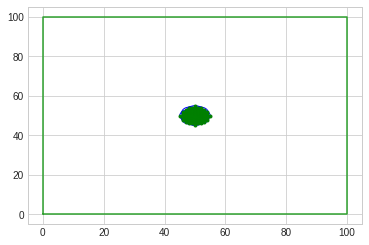

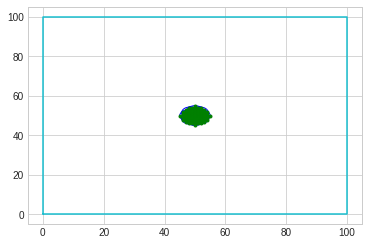

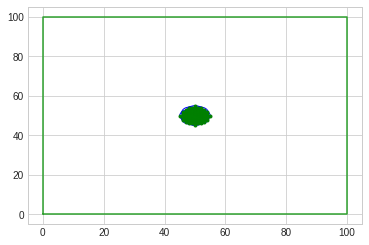

In [24]:
init()
#equalize_map()

0.0
0.0
16.12
16.12
16.12


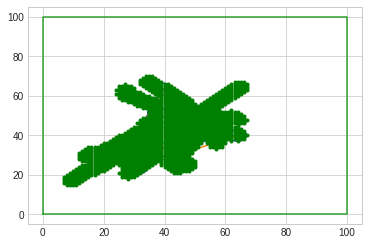

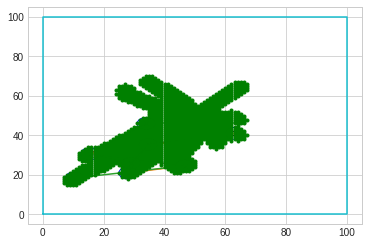

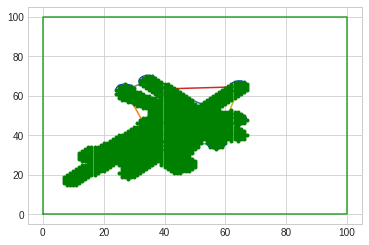

In [25]:
smart_scatter()
#equalize_map()

In [26]:
for swarm in population:
    for drone in swarm.drones:
        print(drone, drone.nn.weights1)

0 [[0.79537157 0.81398949 0.92288213 0.69979421]
 [0.04795032 0.37446152 0.03360429 0.12346023]
 [0.08156554 0.43254817 0.54419527 0.30768374]
 [0.21770856 0.37410488 0.03928834 0.03572528]
 [0.39332703 0.76567802 0.81946075 0.22189277]
 [0.64480717 0.55076142 0.4872686  0.18151773]]
1 [[0.14504535 0.73438752 0.31741483 0.81391615]
 [0.62437548 0.03998916 0.56248682 0.20368019]
 [0.80250433 0.20746531 0.78983886 0.71928922]
 [0.65917199 0.47668204 0.76878678 0.95221547]
 [0.0569594  0.7470785  0.30578052 0.9595221 ]
 [0.6372378  0.95216868 0.19296017 0.17851118]]
2 [[0.91263744 0.19442818 0.4356637  0.16746919]
 [0.80172282 0.30396347 0.10482426 0.62366874]
 [0.61819725 0.60573953 0.3691042  0.66186344]
 [0.35353218 0.47537053 0.58667395 0.49973734]
 [0.87305483 0.8953324  0.11527165 0.06107327]
 [0.02070272 0.13129604 0.39351332 0.8687948 ]]
3 [[0.83487441 0.81691371 0.98549222 0.43412903]
 [0.74651311 0.16143422 0.76785287 0.45160094]
 [0.32687237 0.95788183 0.43036453 0.25343399]
 [